In [1]:
import sys 
sys.path.append('..')
from common.config import ConfigTrain as ct
from common.utils_train import sensors
from common.utils_train import header

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import warnings

#modeling part
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier


from scipy.stats import randint

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report,  roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay

import shap

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format',  '{:,}'.format)



def read_in(file1, file2, file3, file4):
    df1 = pd.read_csv(file1, sep = " ", header = 0, names = header)
    df1['dataset'] = "FD001"
    df2 = pd.read_csv(file2, sep = " ", header = 0, names = header)
    df2['dataset'] = "FD002"
    df3 = pd.read_csv(file3, sep = " ", header = 0, names = header)
    df3['dataset'] = "FD003"
    df4 = pd.read_csv(file4, sep = " ", header = 0, names = header)
    df4['dataset'] = "FD004"
    return df1, df2, df3, df4

def concatenation(df1, df2, df3, df4):
    train = pd.concat([df1, df2, df3, df4], ignore_index=True)
    train = train.drop(["blank1", "blank2"], axis = 1)
    return train


def remining_cycles(train):
    maxi_df = pd.DataFrame(train.groupby(["esn", "dataset"])["cycles"].max().reset_index())
    maxi_df.rename(columns = {"cycles" : "max_cycles"}, inplace = True)
    train = train.merge(maxi_df, how = "left", on = ["esn", "dataset"])
    train['rul'] = train['cycles'] - train['max_cycles']
    return train

n_clusters = 6
def clustering(train):
    kmeans = KMeans(n_clusters = n_clusters, 
                    random_state = 0, 
                    n_init="auto").fit(train[["opset1","opset2"]].to_numpy())
    train["condition"] = kmeans.labels_
    return train



def one_hot(df, column, names=None):
    enc = OneHotEncoder()
    labelenc = LabelEncoder()
    if names == None:
        names = df[column].unique().tolist()
    df['column_cat'] = labelenc.fit_transform(df[column])
    enc_df = pd.DataFrame(enc.fit_transform(df[column].to_numpy().reshape(-1,1)).toarray(), columns = names)
    enc_df.drop(columns = names[0], inplace = True)
    df = pd.concat([df, enc_df], axis = 1)
    df.drop(columns = column, inplace = True)
    df.drop(columns = 'column_cat', inplace = True)
    return df

In [2]:
df1, df2, df3, df4 = read_in(ct.location1, ct.location2, ct.location3, ct.location4)

In [3]:
train = concatenation(df1, df2, df3, df4)
train = remining_cycles(train)
train = clustering(train)

In [4]:
train

esn  cycles  opset1  opset2   TRA     T2    T24      T30      T50  \
0         1       2  0.0019 -0.0003 100.0 518.67 642.15 1,591.82 1,403.14   
1         1       3 -0.0043  0.0003 100.0 518.67 642.35 1,587.99  1,404.2   
2         1       4  0.0007     0.0 100.0 518.67 642.35 1,582.79 1,401.87   
3         1       5 -0.0019 -0.0002 100.0 518.67 642.37 1,582.85 1,406.22   
4         1       6 -0.0043 -0.0001 100.0 518.67  642.1 1,584.47 1,398.37   
...     ...     ...     ...     ...   ...    ...    ...      ...      ...   
160350  249     251  9.9998    0.25 100.0 489.05 605.33 1,516.36 1,315.28   
160351  249     252  0.0028  0.0015 100.0 518.67 643.42 1,598.92 1,426.77   
160352  249     253  0.0029     0.0 100.0 518.67 643.68 1,607.72 1,430.56   
160353  249     254 35.0046    0.84 100.0 449.44 555.77 1,381.29 1,148.18   
160354  249     255  42.003    0.84 100.0  445.0 549.85 1,369.75 1,147.45   

          P2   P15    P30       Nf       Nc  epr  Ps30    phi      NRf  \
0      14.62 21.61 553.75 2,388.04 9,044.07  1.3 47.49 522.28 2,388.07   
1      14.62 21.61 554.26 2,388.08 9,052.94  1.3 47.27 522.42 2,388.03   
2      14.62 21.61 554.45 2,388.11 9,049.48  1.3 47.13 522.86 2,388.08   
3      14.62 21.61  554.0 2,388.06 9,055.15  1.3 47.28 522.19 2,388.04   
4      14.62 21.61 554.67 2,388.02 9,049.68  1.3 47.16 521.68 2,388.03   
...      ...   ...    ...      ...      ...  ...   ...    ...      ...   
160350 10.52 15.46 404.59 2,319.66 8,840.16 1.27 46.08 380.16 2,388.73   
160351 14.62 21.57 567.59 2,388.47 9,117.12 1.31 48.04 535.02 2,388.46   
160352 14.62 21.57 569.04 2,388.51 9,126.53 1.31 48.24 535.41 2,388.48   
160353  5.48  7.96 199.93 2,223.78 8,403.64 1.05 42.53 187.92 2,388.83   
160354  3.91  5.69 142.47 2,212.52 8,391.31 1.05  42.6 134.32 2,388.66   

            NRc    BPR  farB  htBleed  Nf_dmd  PCNfR_dmd   W31     W32  \
0      8,131.49 8.4318  0.03      392    2388      100.0  39.0 23.4236   
1      8,133.23 8.4178  0.03      390    2388      100.0 38.95 23.3442   
2      8,133.83 8.3682  0.03      392    2388      100.0 38.88 23.3739   
3       8,133.8 8.4294  0.03      393    2388      100.0  38.9 23.4044   
4      8,132.85 8.4108  0.03      391    2388      100.0 38.98 23.3669   
...         ...    ...   ...      ...     ...        ...   ...     ...   
160350 8,185.69 8.4541  0.03      372    2319      100.0 29.11 17.5234   
160351 8,185.47 8.2221  0.03      396    2388      100.0 39.38 23.7151   
160352 8,193.94 8.2525  0.03      395    2388      100.0 39.78  23.827   
160353 8,125.64 9.0515  0.02      337    2223      100.0 15.26  9.0774   
160354 8,144.33 9.1207  0.02      333    2212      100.0 10.66  6.4341   

       dataset  max_cycles  rul  condition  
0        FD001         192 -190          2  
1        FD001         192 -189          2  
2        FD001         192 -188          2  
3        FD001         192 -187          2  
4        FD001         192 -186          2  
...        ...         ...  ...        ...  
160350   FD004         255   -4          0  
160351   FD004         255   -3          2  
160352   FD004         255   -2          2  
160353   FD004         255   -1          1  
160354   FD004         255    0          4  

[160355 rows x 30 columns]

In [14]:
def failure_mode(row):
    """Function that creates column with information if there is single HPC Failure Mode (value 0) or HPC + Fan (value 1) FM"""
    return 1 if row['dataset'] in ["FD003", "FD004"] else 0

    

In [15]:
train['HPC_Fan'] = train.apply(failure_mode, axis = 1)

In [16]:
train

esn  cycles  opset1  opset2   TRA     T2    T24      T30      T50  \
0         1       2  0.0019 -0.0003 100.0 518.67 642.15 1,591.82 1,403.14   
1         1       3 -0.0043  0.0003 100.0 518.67 642.35 1,587.99  1,404.2   
2         1       4  0.0007     0.0 100.0 518.67 642.35 1,582.79 1,401.87   
3         1       5 -0.0019 -0.0002 100.0 518.67 642.37 1,582.85 1,406.22   
4         1       6 -0.0043 -0.0001 100.0 518.67  642.1 1,584.47 1,398.37   
...     ...     ...     ...     ...   ...    ...    ...      ...      ...   
160350  249     251  9.9998    0.25 100.0 489.05 605.33 1,516.36 1,315.28   
160351  249     252  0.0028  0.0015 100.0 518.67 643.42 1,598.92 1,426.77   
160352  249     253  0.0029     0.0 100.0 518.67 643.68 1,607.72 1,430.56   
160353  249     254 35.0046    0.84 100.0 449.44 555.77 1,381.29 1,148.18   
160354  249     255  42.003    0.84 100.0  445.0 549.85 1,369.75 1,147.45   

          P2   P15    P30       Nf       Nc  epr  Ps30    phi      NRf  \
0      14.62 21.61 553.75 2,388.04 9,044.07  1.3 47.49 522.28 2,388.07   
1      14.62 21.61 554.26 2,388.08 9,052.94  1.3 47.27 522.42 2,388.03   
2      14.62 21.61 554.45 2,388.11 9,049.48  1.3 47.13 522.86 2,388.08   
3      14.62 21.61  554.0 2,388.06 9,055.15  1.3 47.28 522.19 2,388.04   
4      14.62 21.61 554.67 2,388.02 9,049.68  1.3 47.16 521.68 2,388.03   
...      ...   ...    ...      ...      ...  ...   ...    ...      ...   
160350 10.52 15.46 404.59 2,319.66 8,840.16 1.27 46.08 380.16 2,388.73   
160351 14.62 21.57 567.59 2,388.47 9,117.12 1.31 48.04 535.02 2,388.46   
160352 14.62 21.57 569.04 2,388.51 9,126.53 1.31 48.24 535.41 2,388.48   
160353  5.48  7.96 199.93 2,223.78 8,403.64 1.05 42.53 187.92 2,388.83   
160354  3.91  5.69 142.47 2,212.52 8,391.31 1.05  42.6 134.32 2,388.66   

            NRc    BPR  farB  htBleed  Nf_dmd  PCNfR_dmd   W31     W32  \
0      8,131.49 8.4318  0.03      392    2388      100.0  39.0 23.4236   
1      8,133.23 8.4178  0.03      390    2388      100.0 38.95 23.3442   
2      8,133.83 8.3682  0.03      392    2388      100.0 38.88 23.3739   
3       8,133.8 8.4294  0.03      393    2388      100.0  38.9 23.4044   
4      8,132.85 8.4108  0.03      391    2388      100.0 38.98 23.3669   
...         ...    ...   ...      ...     ...        ...   ...     ...   
160350 8,185.69 8.4541  0.03      372    2319      100.0 29.11 17.5234   
160351 8,185.47 8.2221  0.03      396    2388      100.0 39.38 23.7151   
160352 8,193.94 8.2525  0.03      395    2388      100.0 39.78  23.827   
160353 8,125.64 9.0515  0.02      337    2223      100.0 15.26  9.0774   
160354 8,144.33 9.1207  0.02      333    2212      100.0 10.66  6.4341   

       dataset  max_cycles  rul  HPC_Fan  c2  c3  c4  c5  c6  
0        FD001         192 -190        0 0.0 1.0 0.0 0.0 0.0  
1        FD001         192 -189        0 0.0 1.0 0.0 0.0 0.0  
2        FD001         192 -188        0 0.0 1.0 0.0 0.0 0.0  
3        FD001         192 -187        0 0.0 1.0 0.0 0.0 0.0  
4        FD001         192 -186        0 0.0 1.0 0.0 0.0 0.0  
...        ...         ...  ...      ...  ..  ..  ..  ..  ..  
160350   FD004         255   -4        1 0.0 0.0 0.0 0.0 0.0  
160351   FD004         255   -3        1 0.0 1.0 0.0 0.0 0.0  
160352   FD004         255   -2        1 0.0 1.0 0.0 0.0 0.0  
160353   FD004         255   -1        1 1.0 0.0 0.0 0.0 0.0  
160354   FD004         255    0        1 0.0 0.0 0.0 1.0 0.0  

[160355 rows x 35 columns]

In [12]:
train = one_hot(train, 'condition', ["c1","c2","c3","c4","c5","c6"])

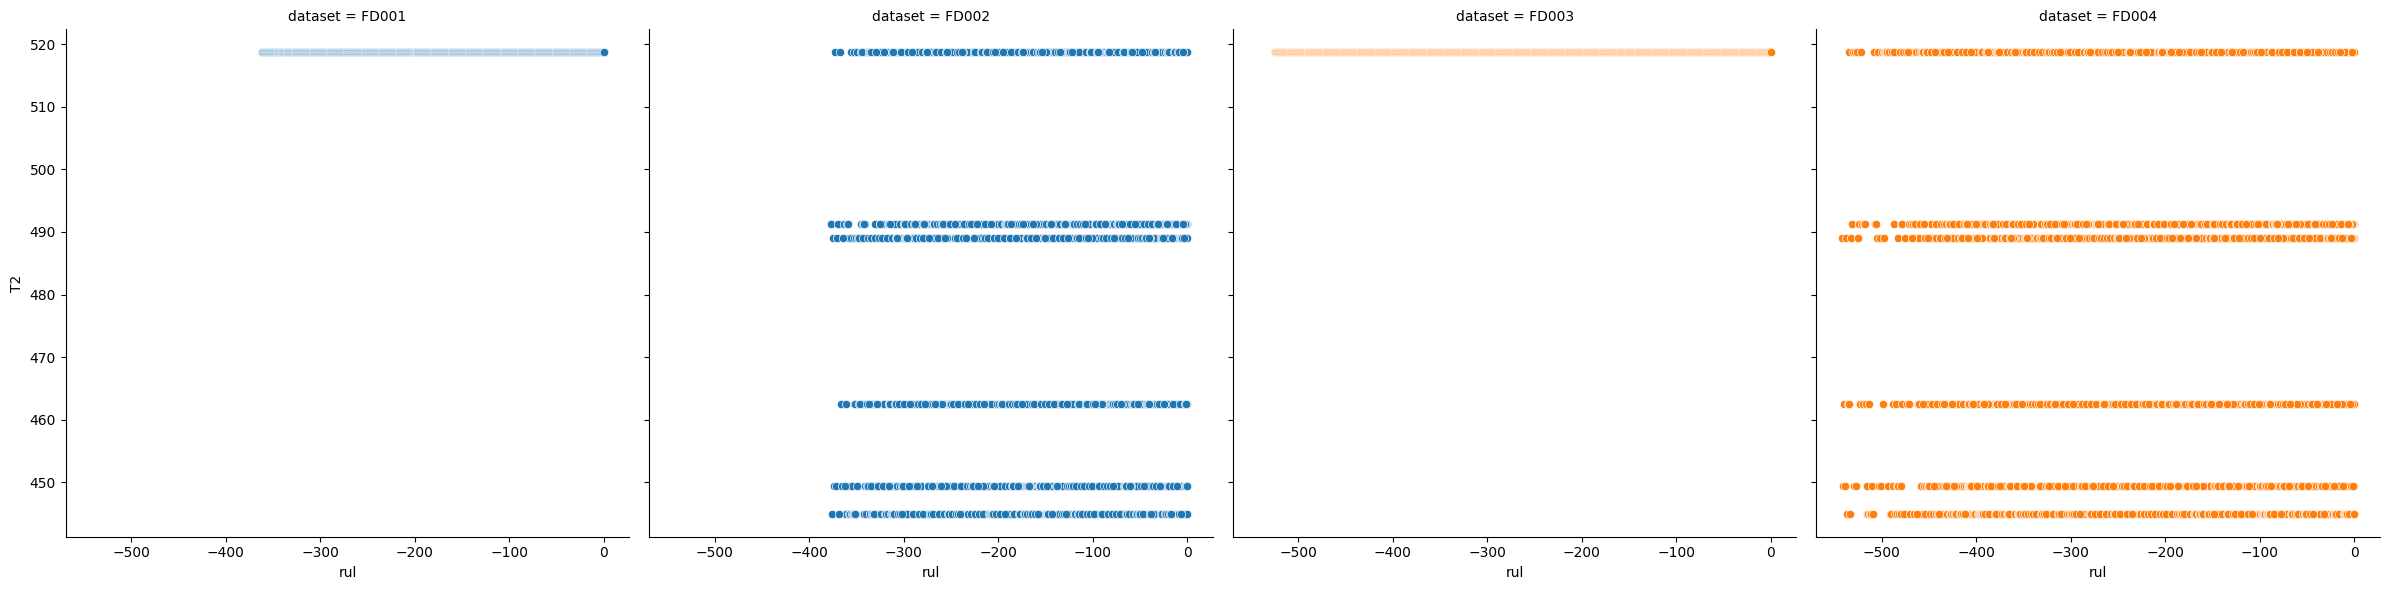

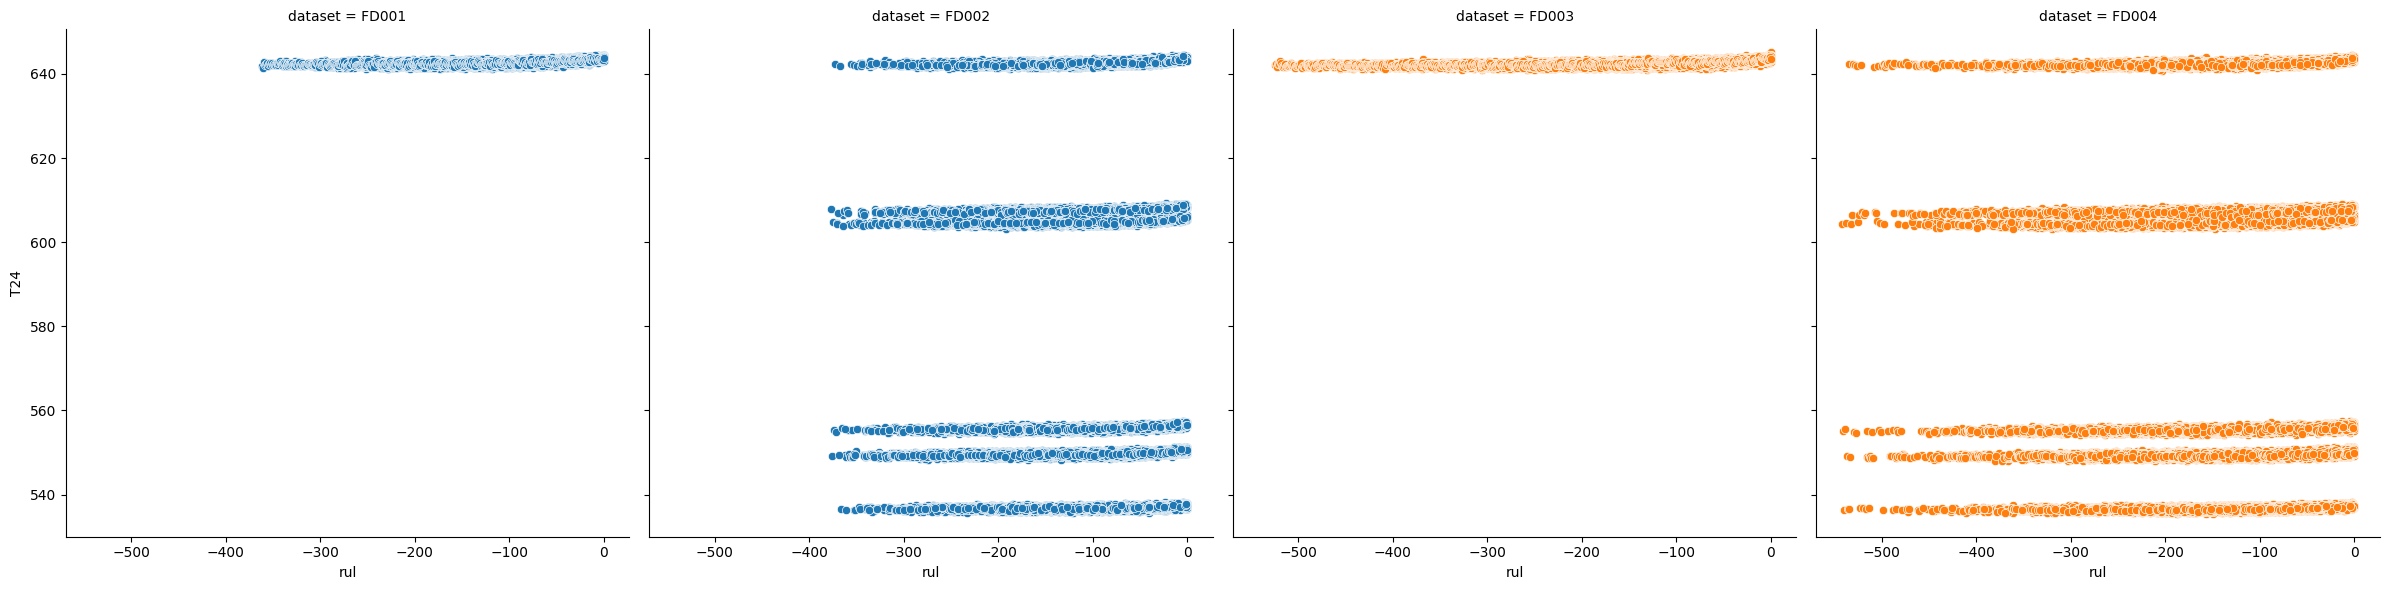

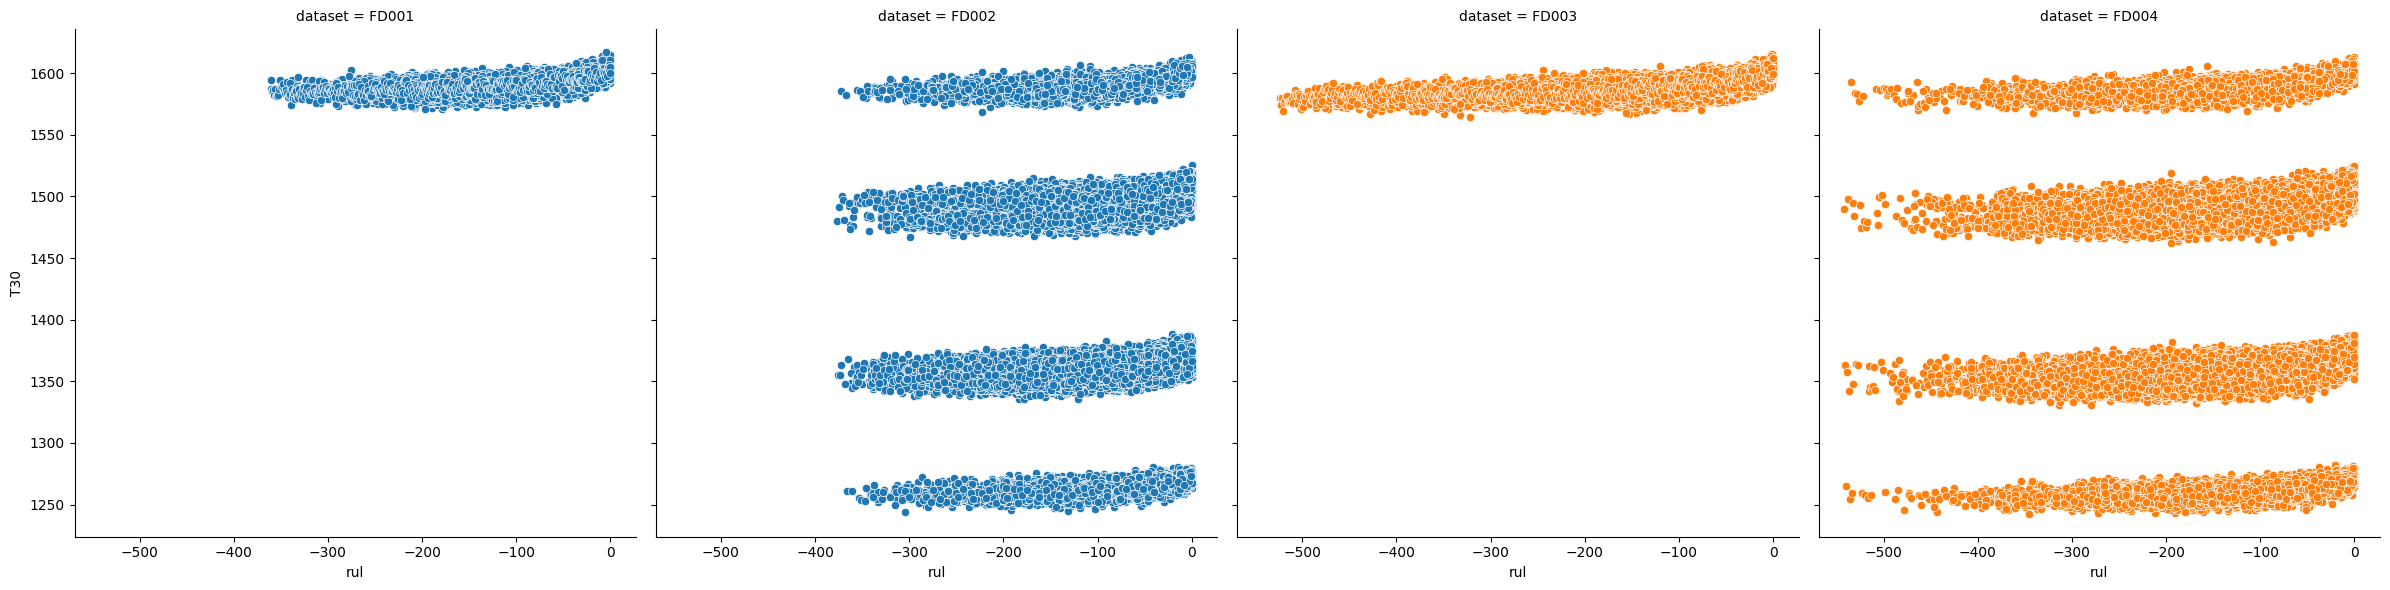

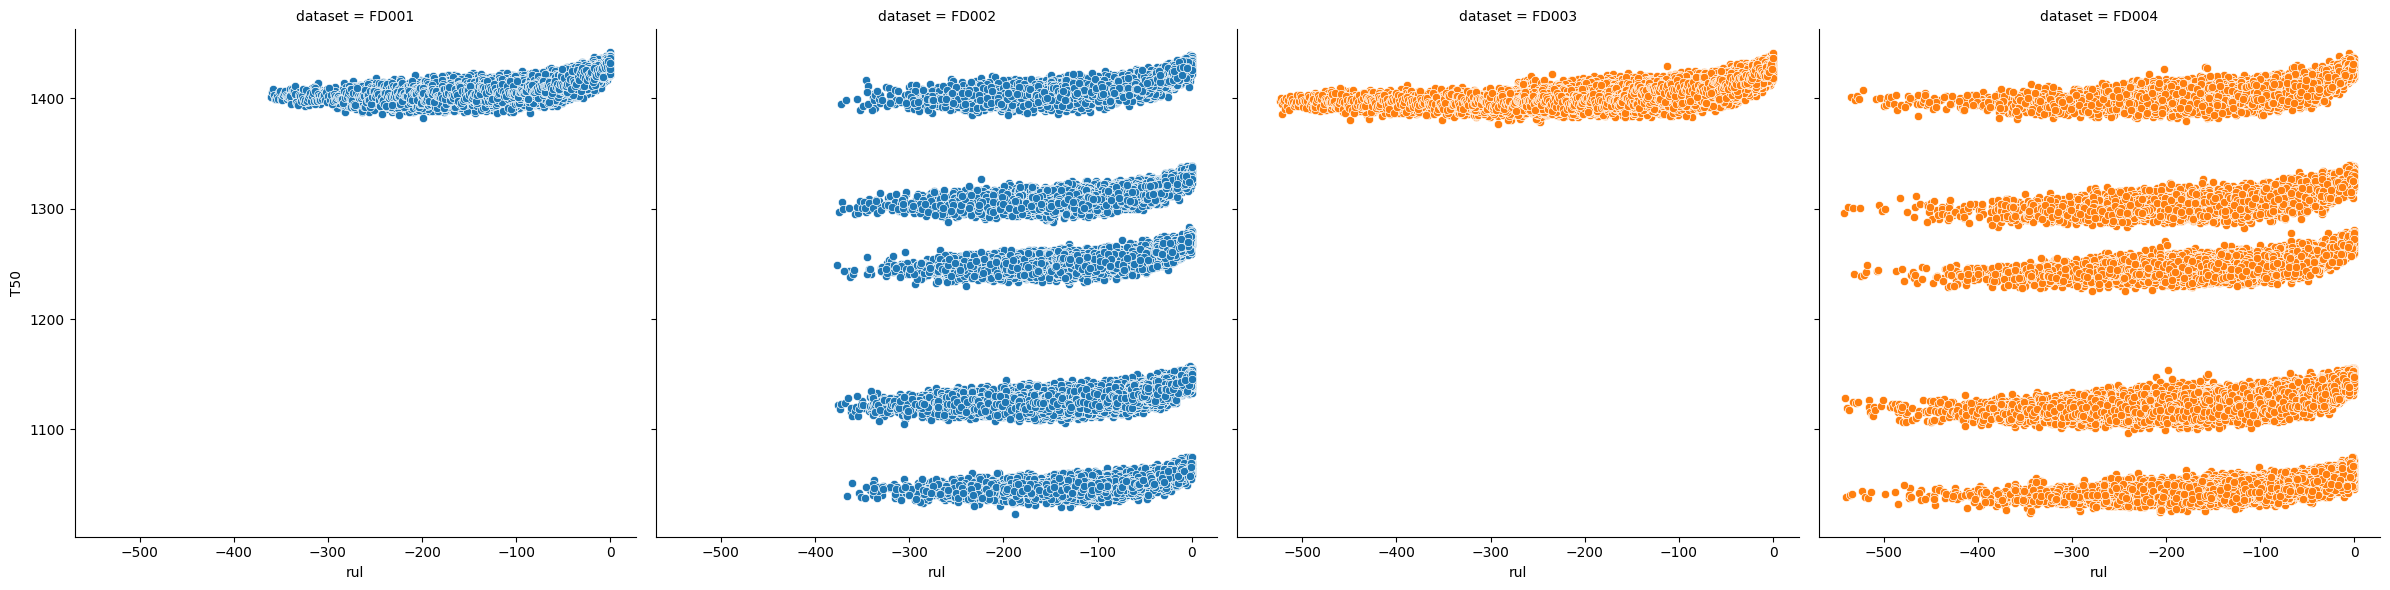

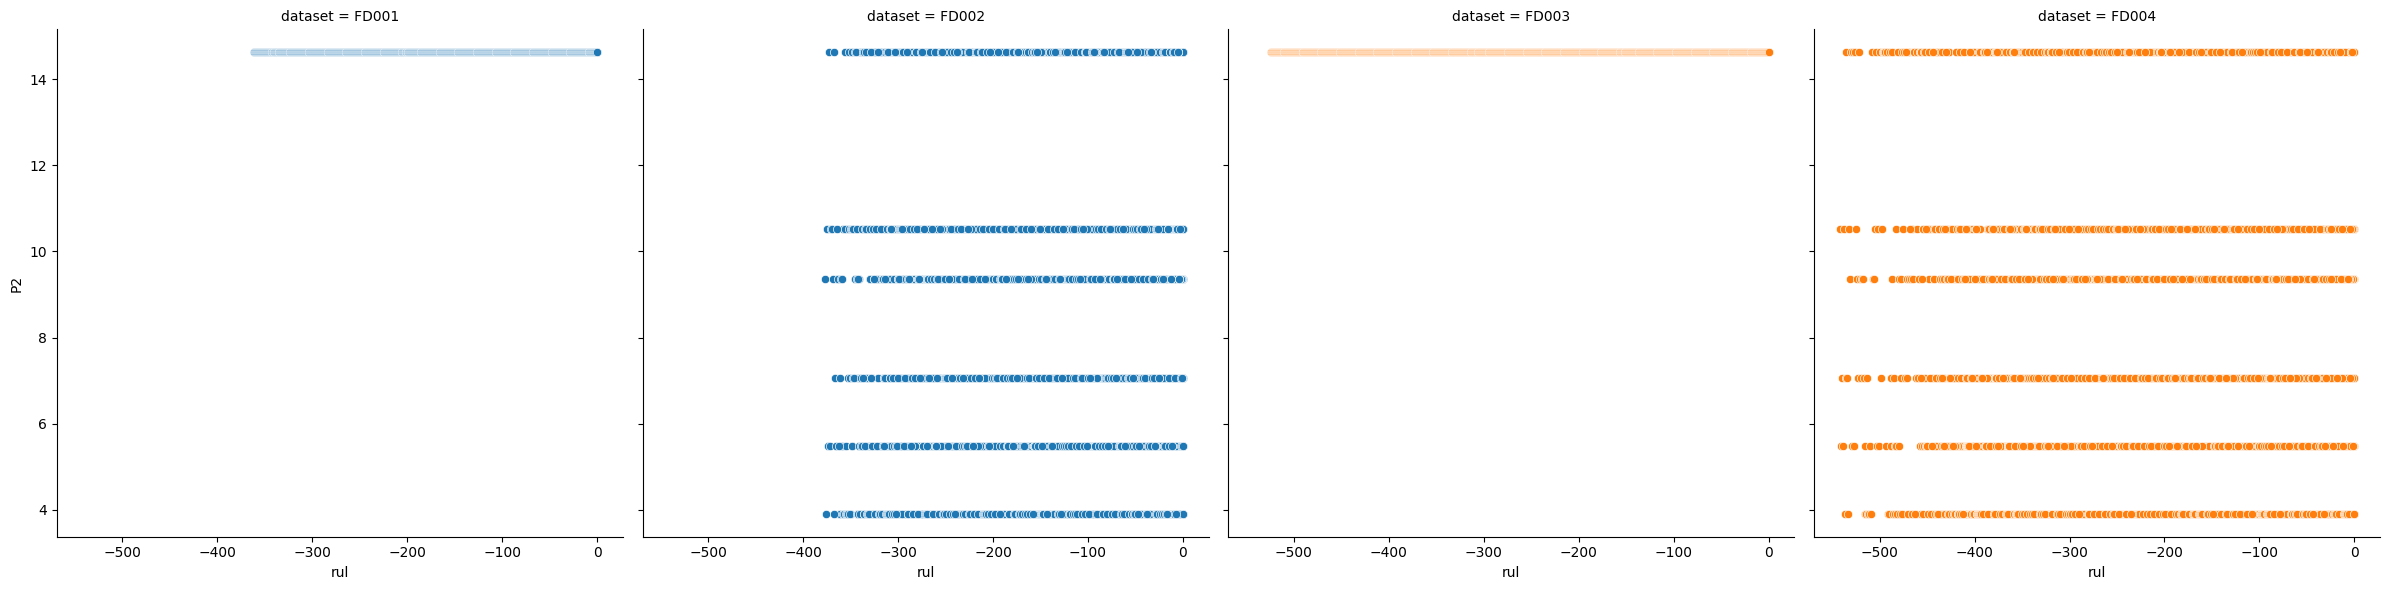

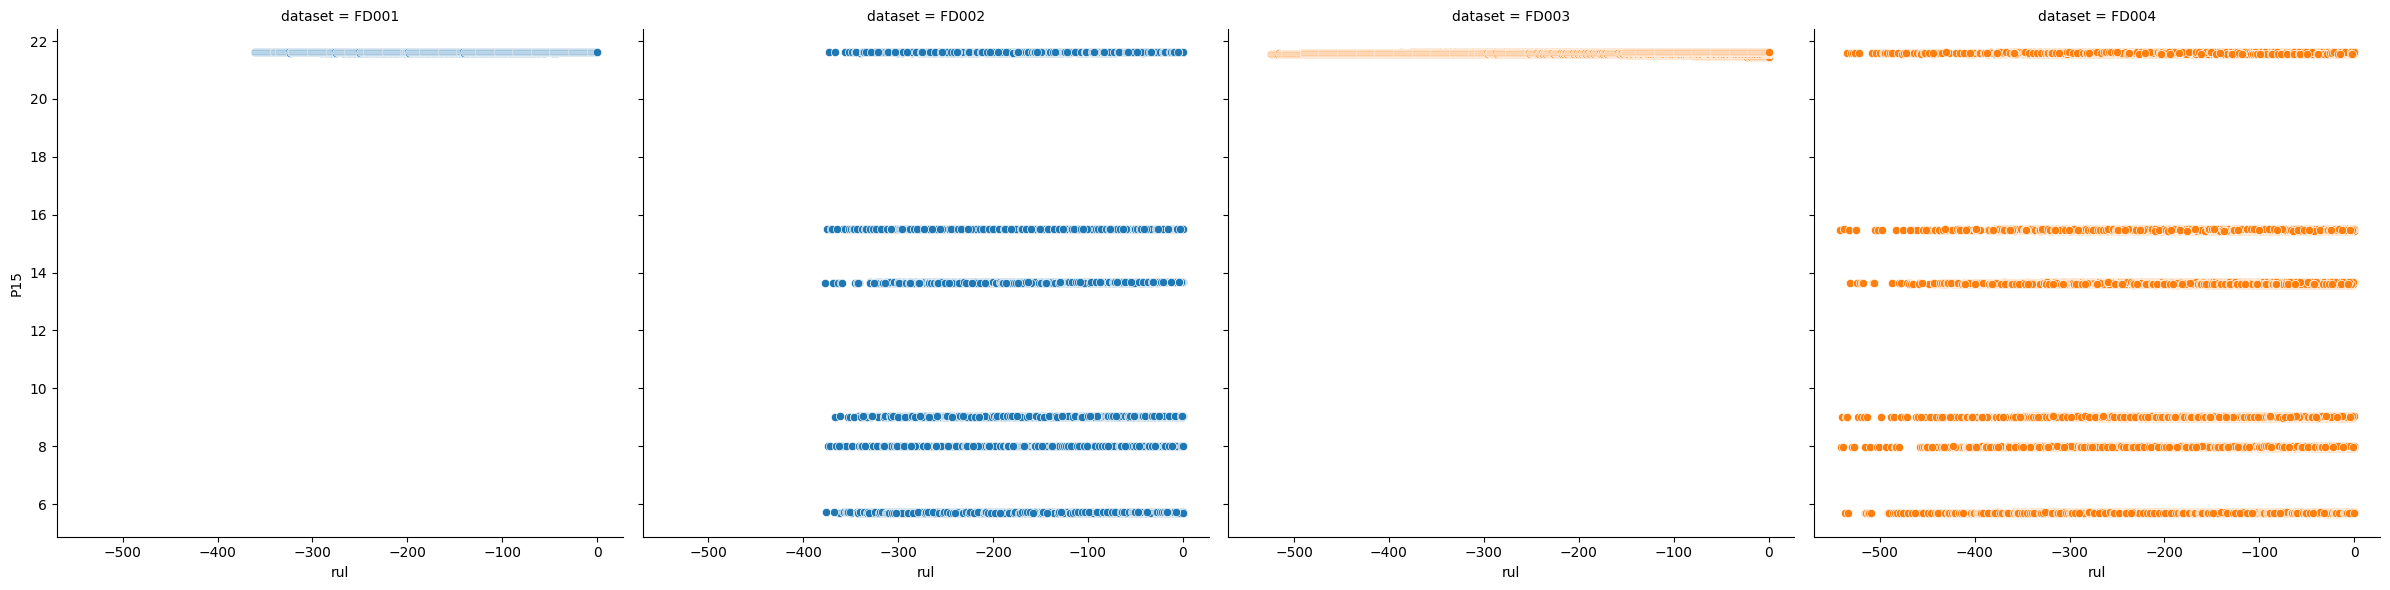

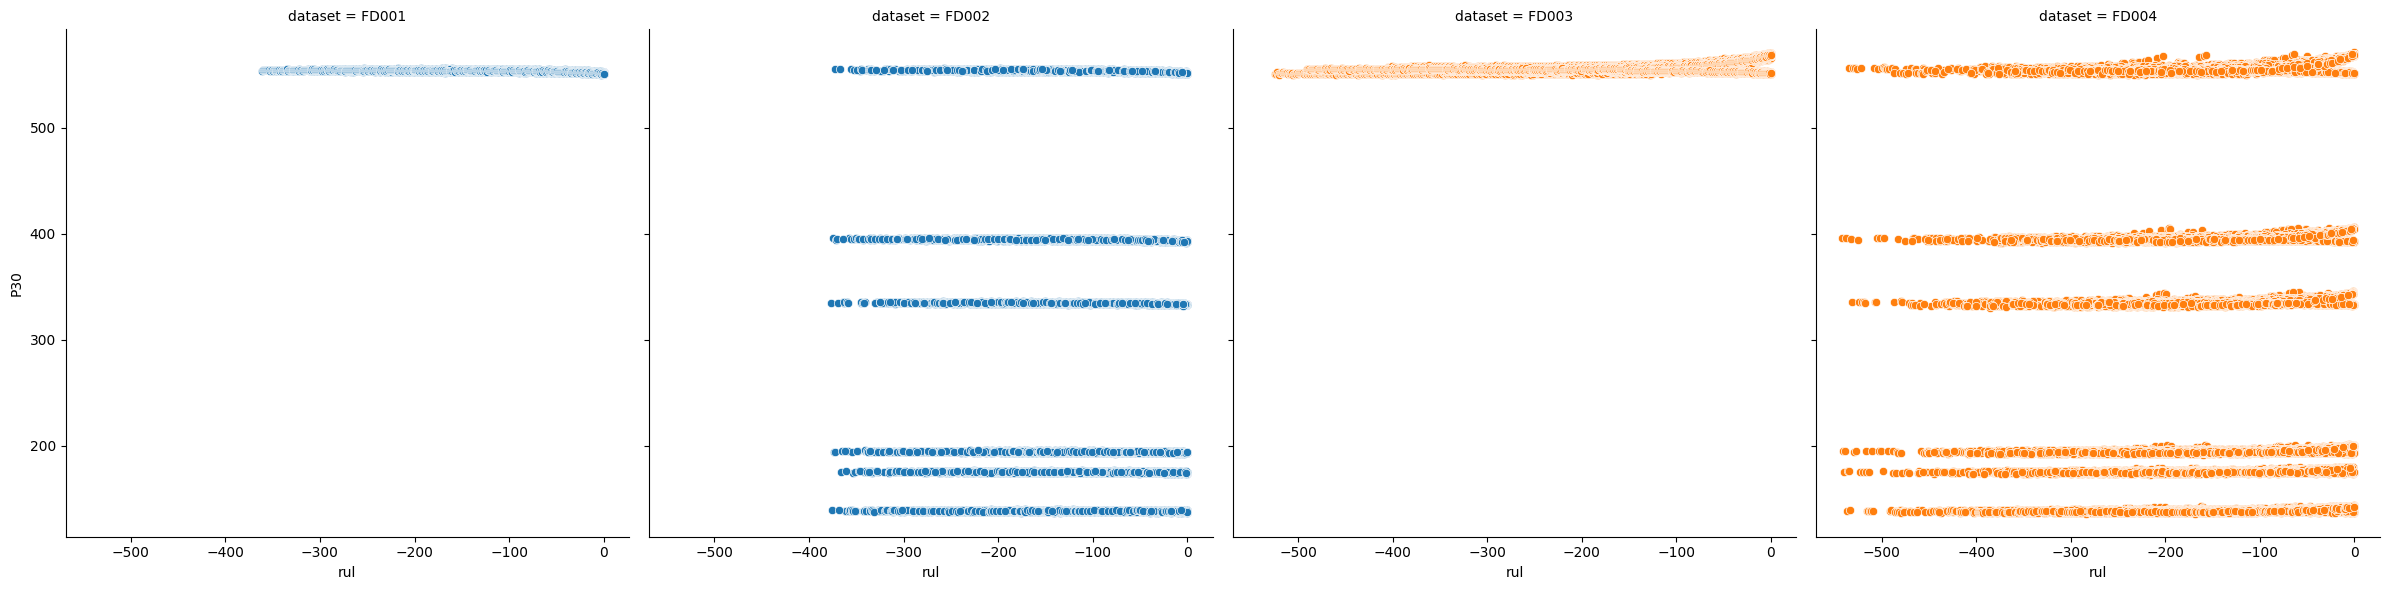

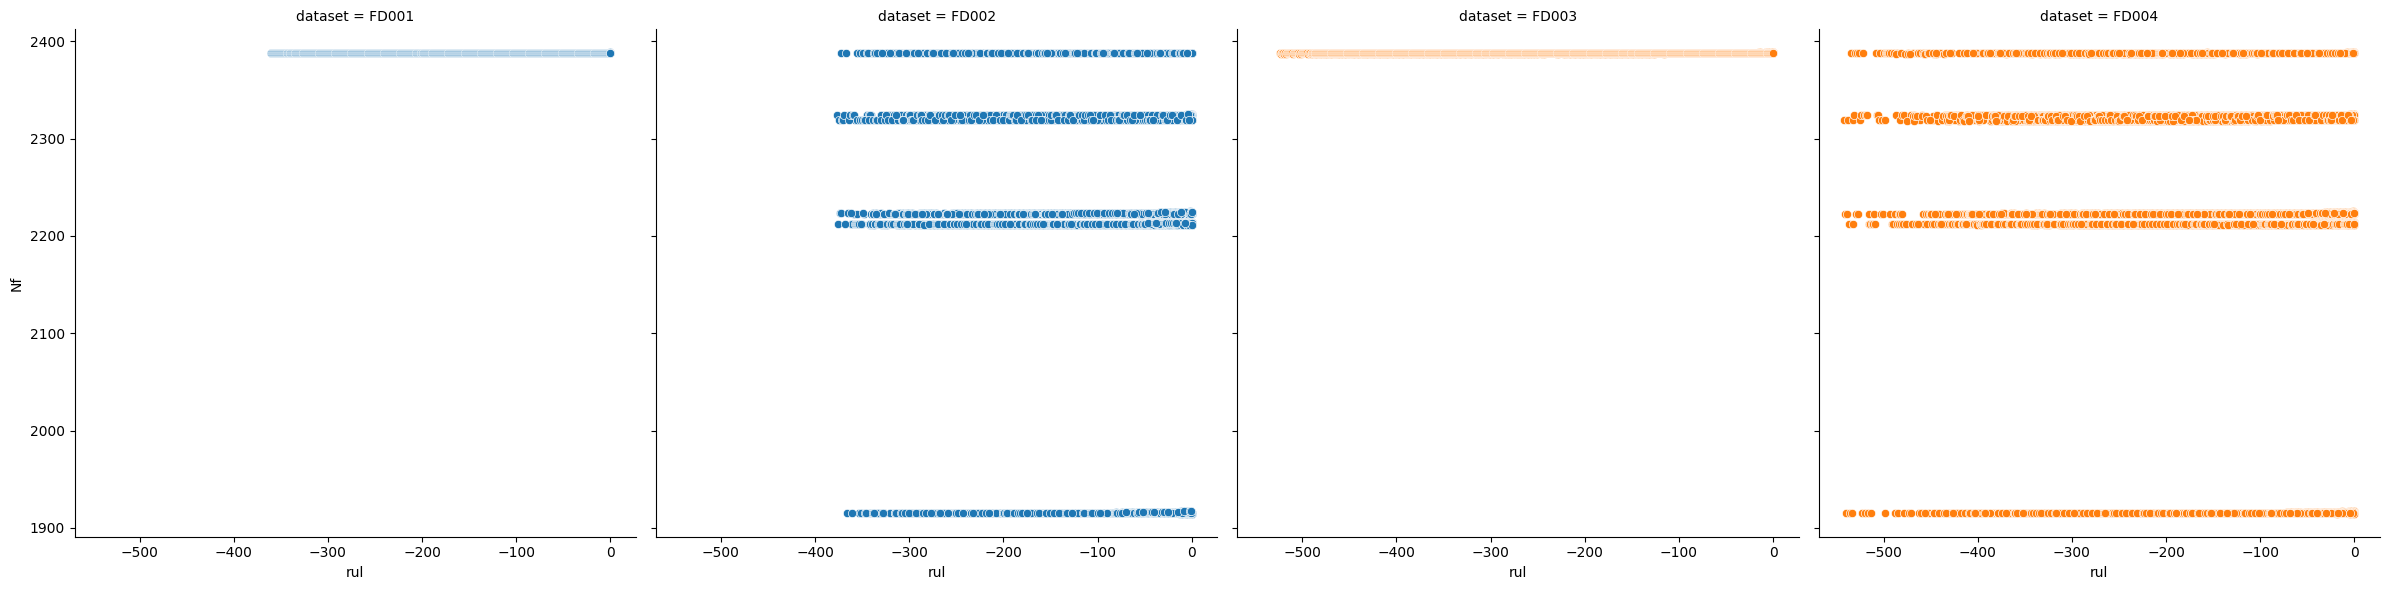

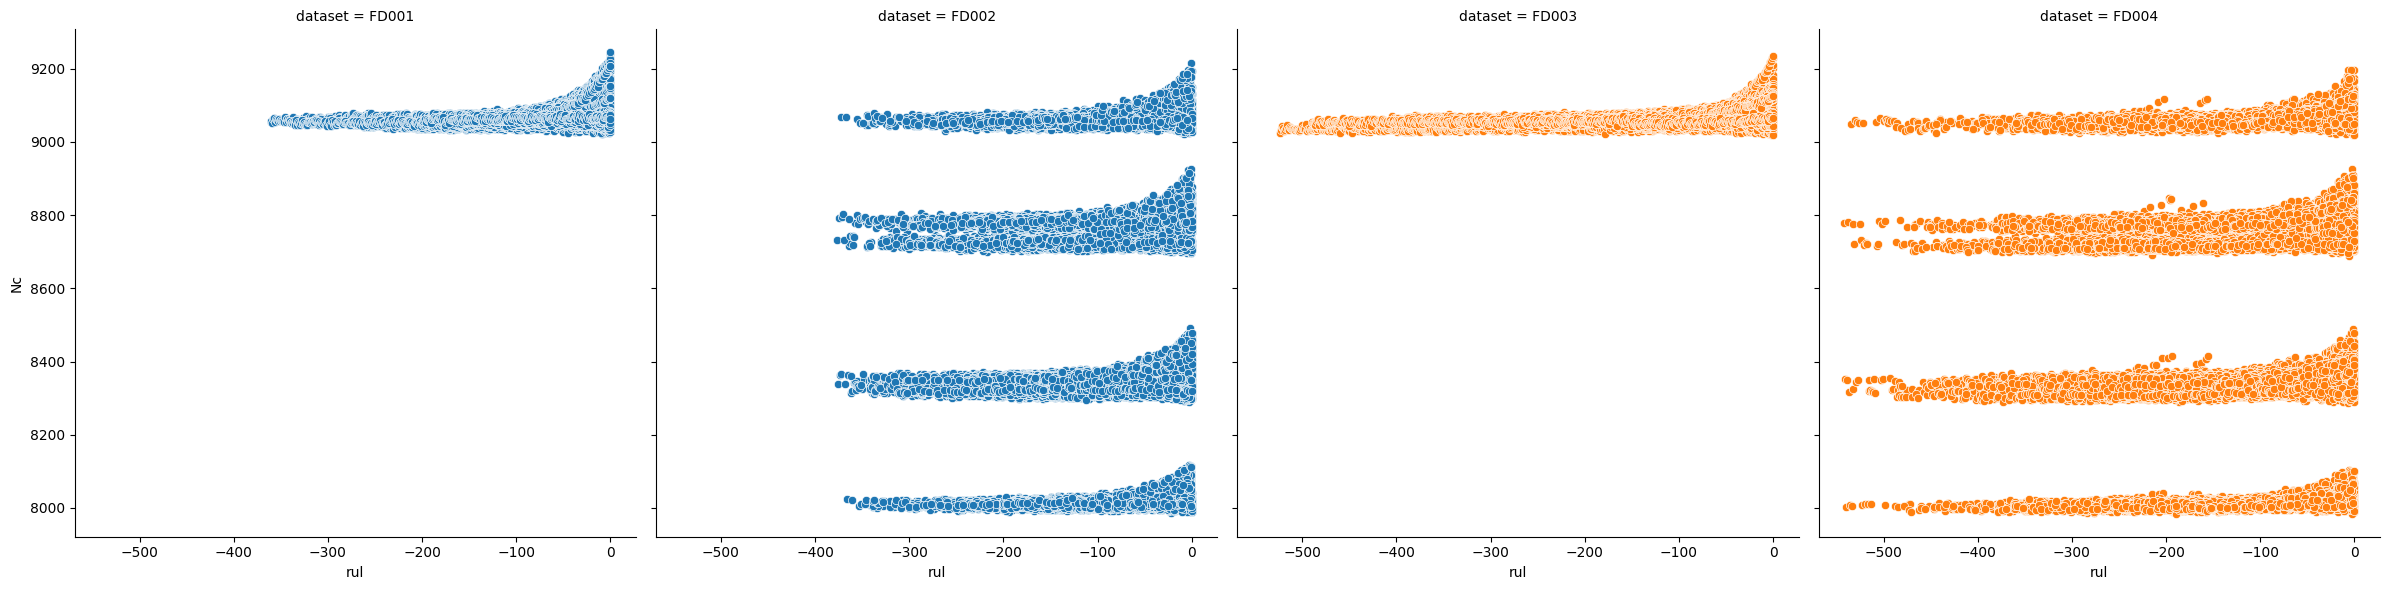

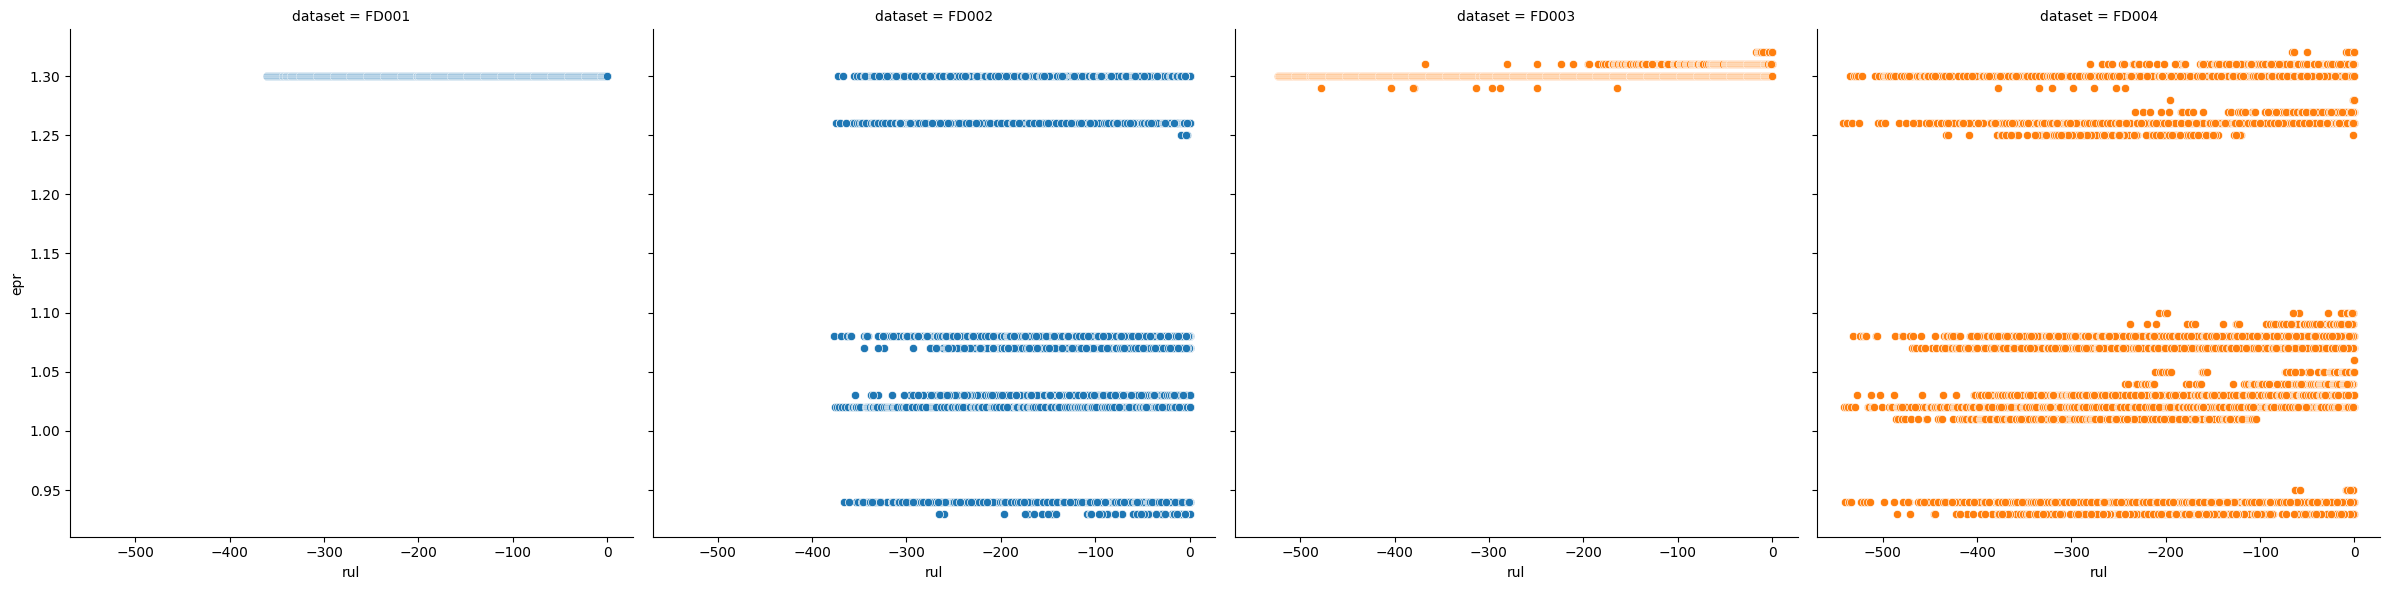

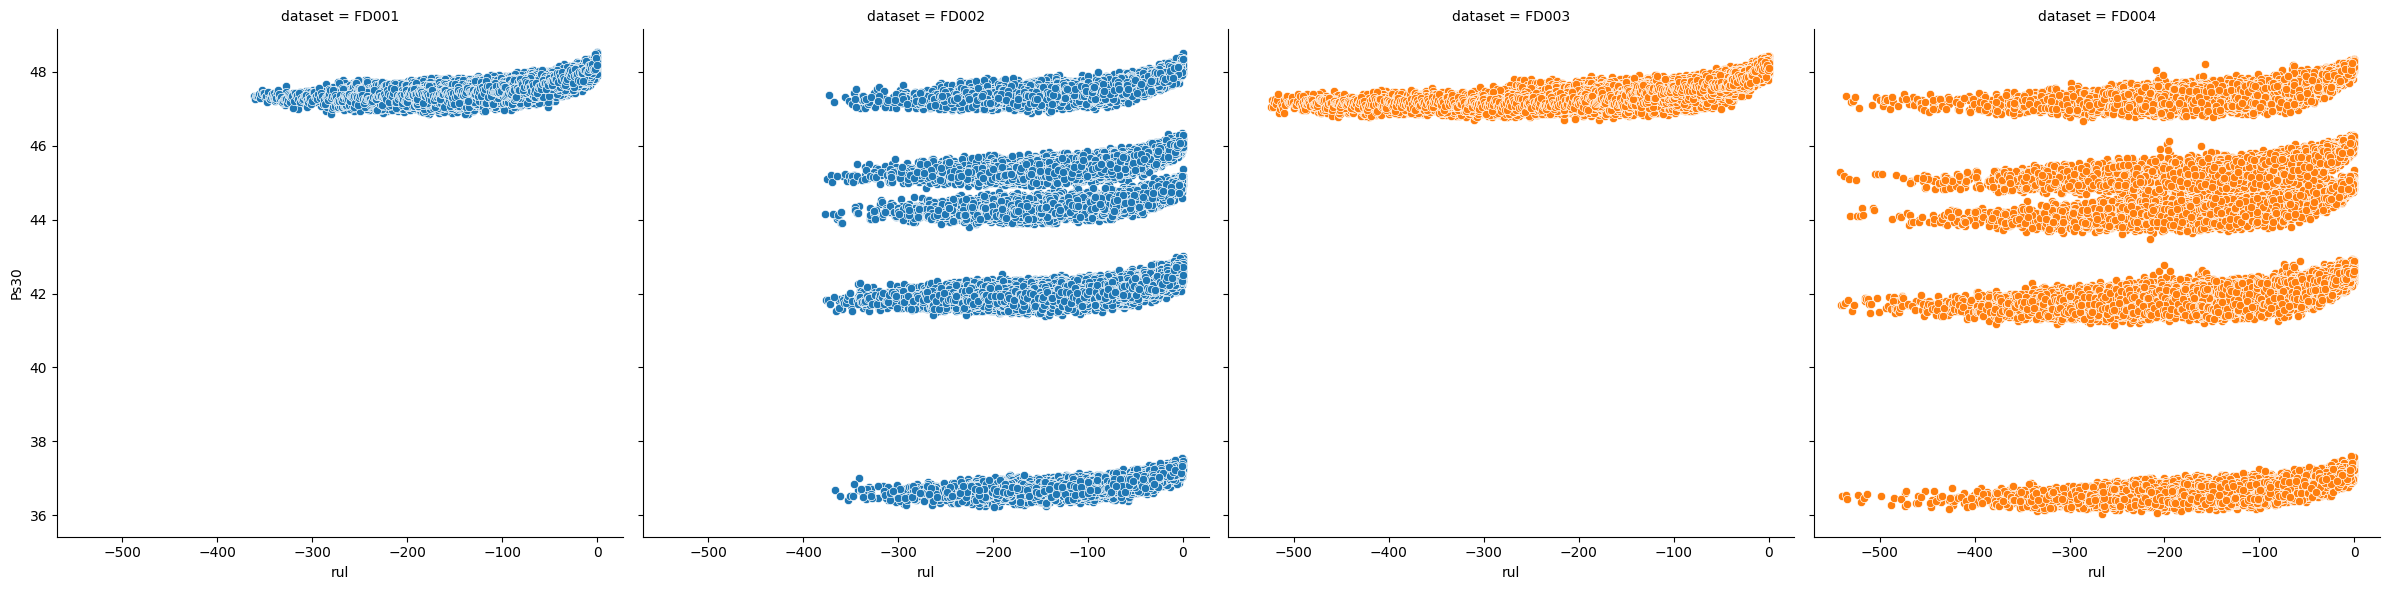

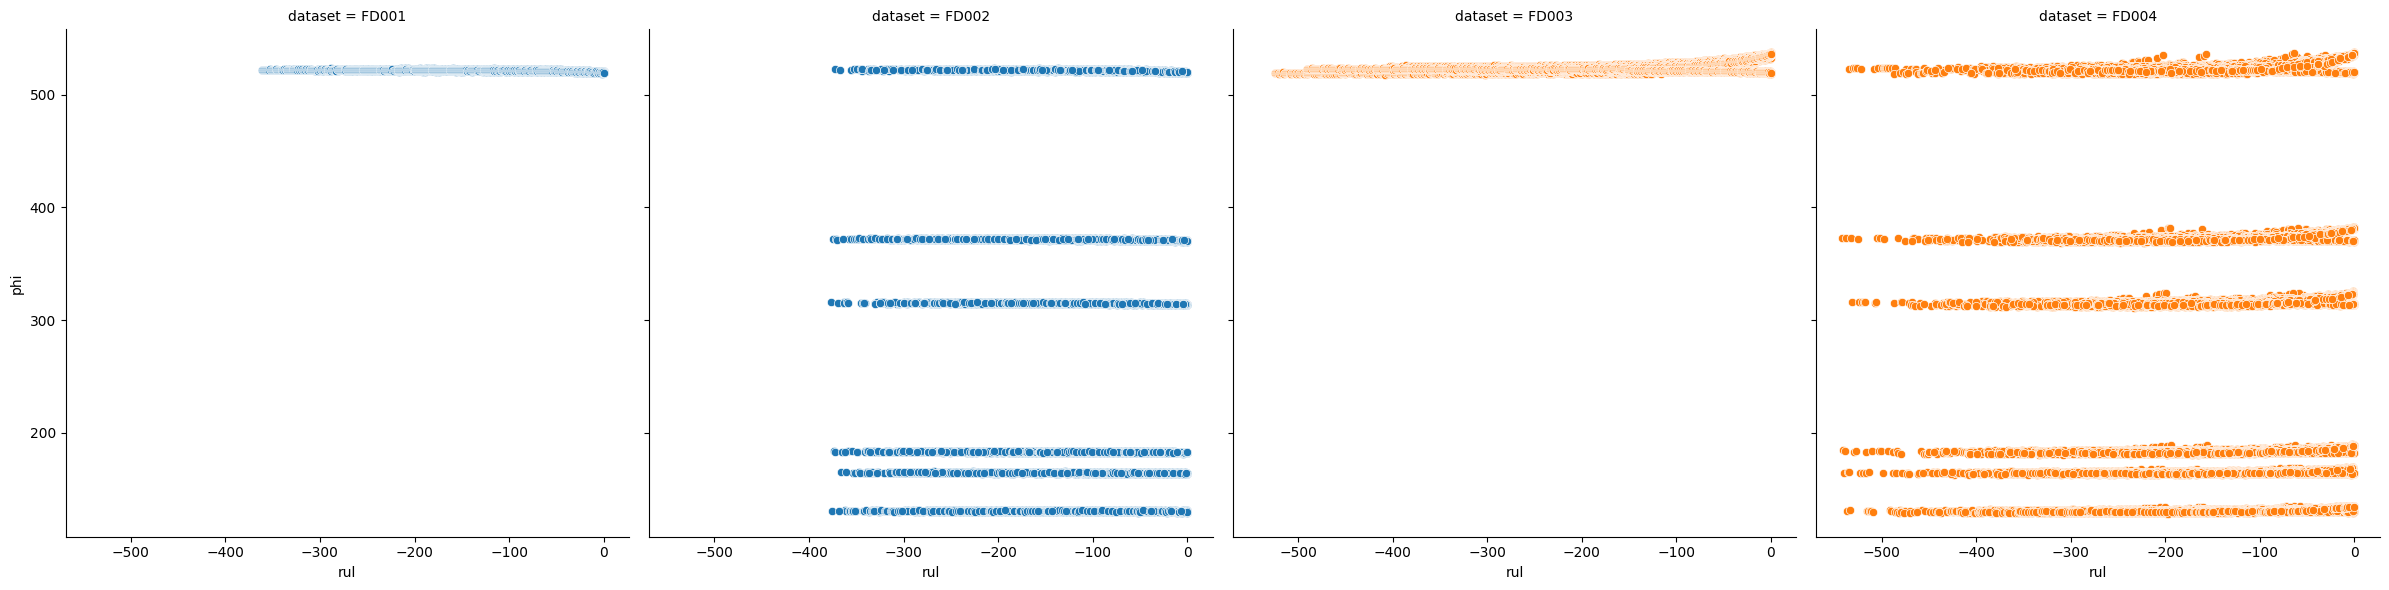

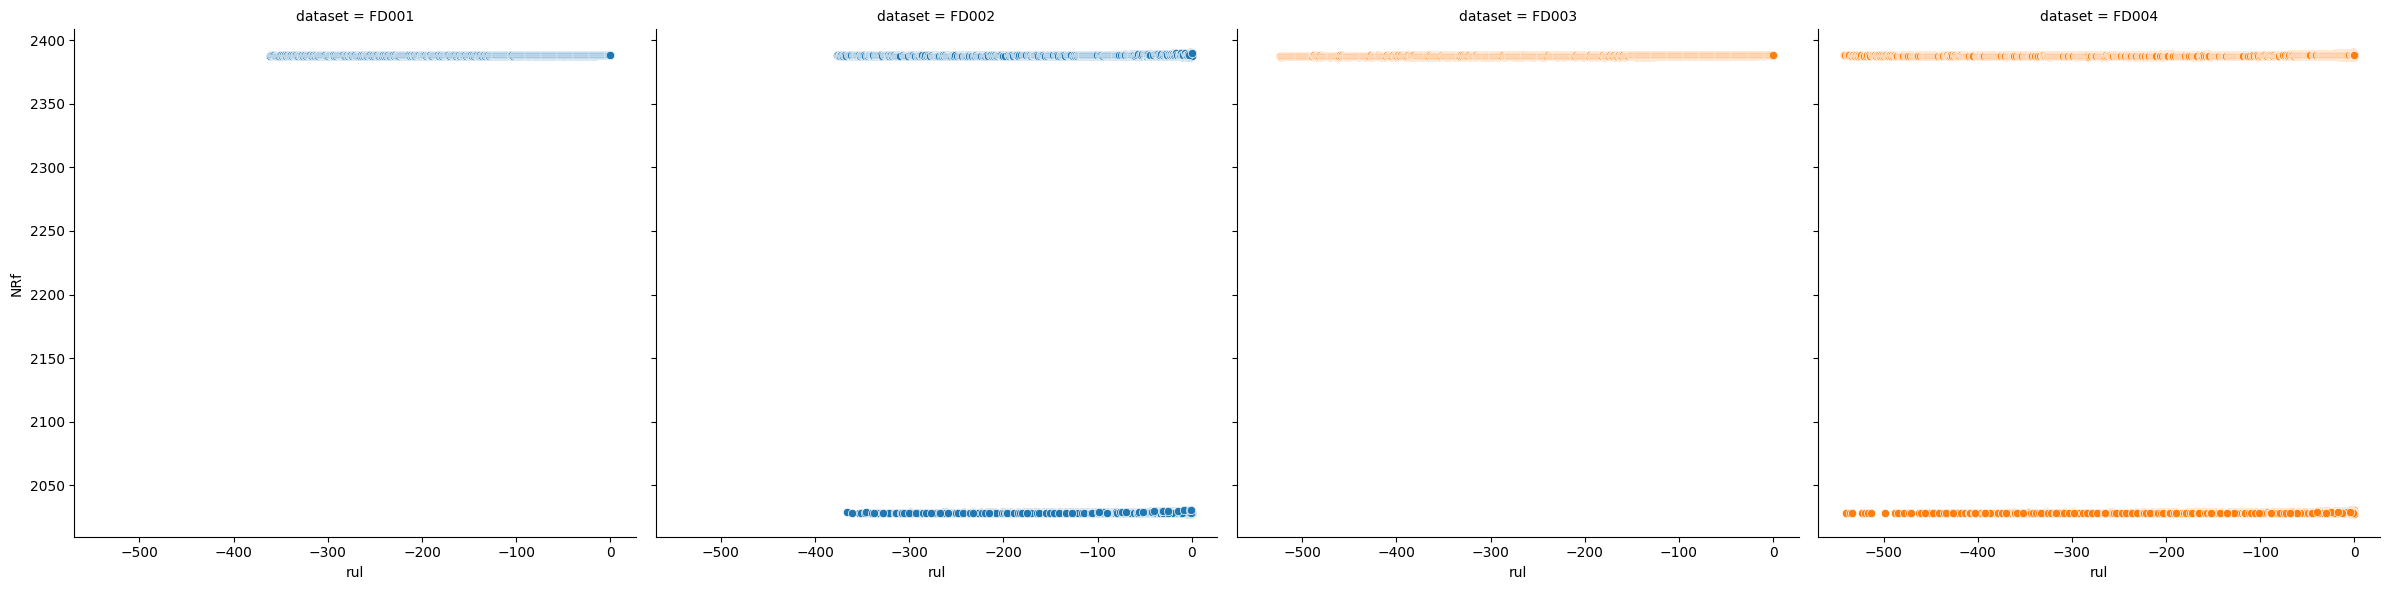

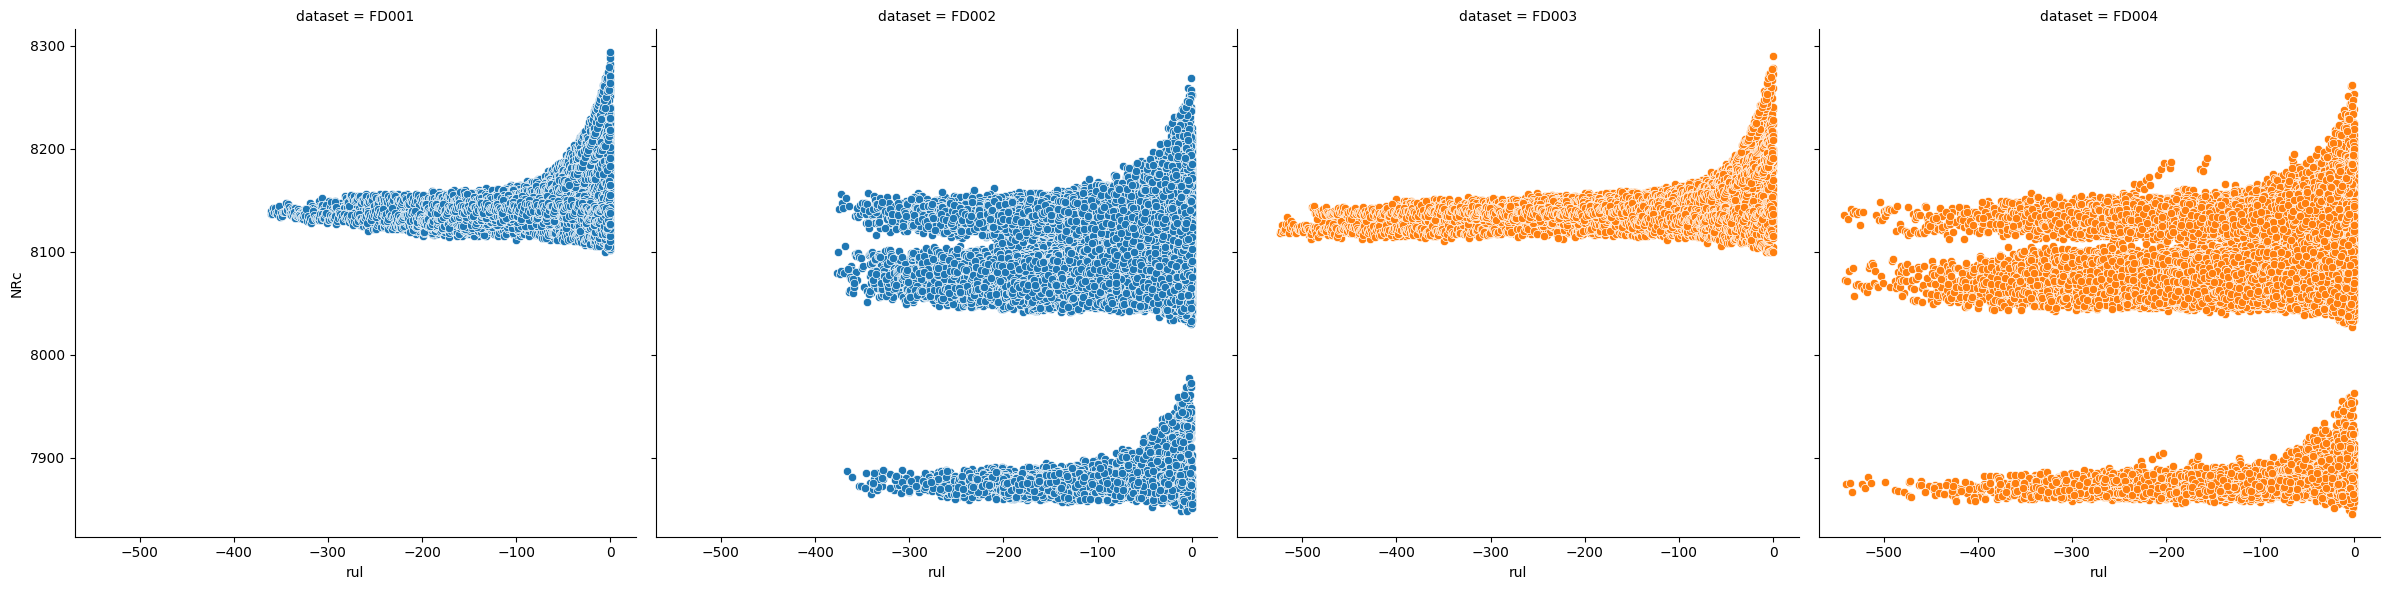

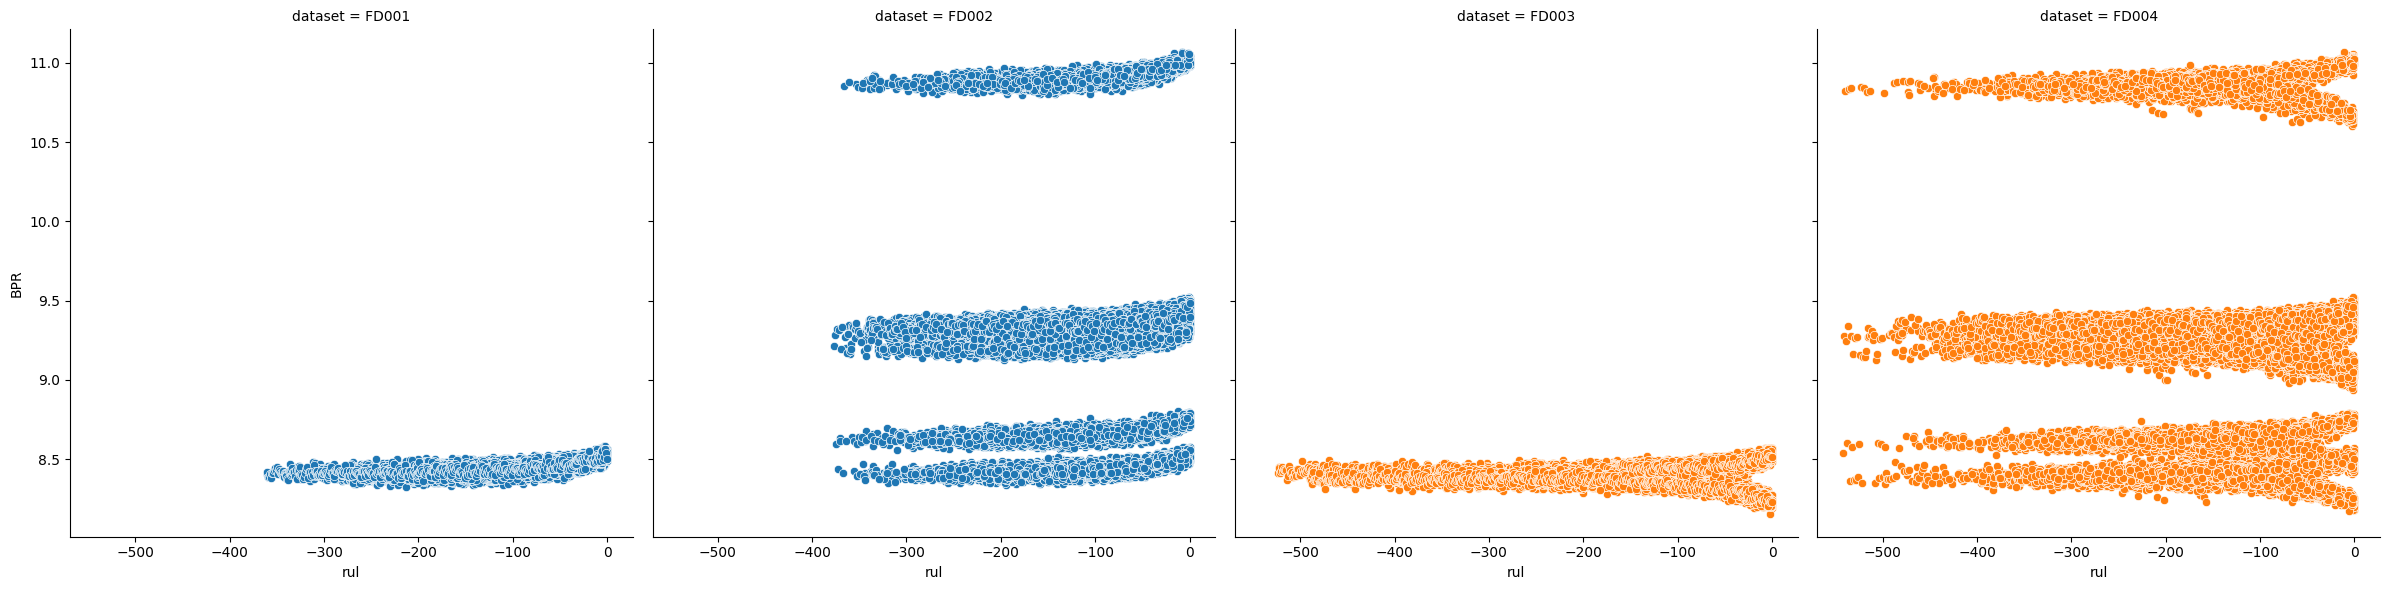

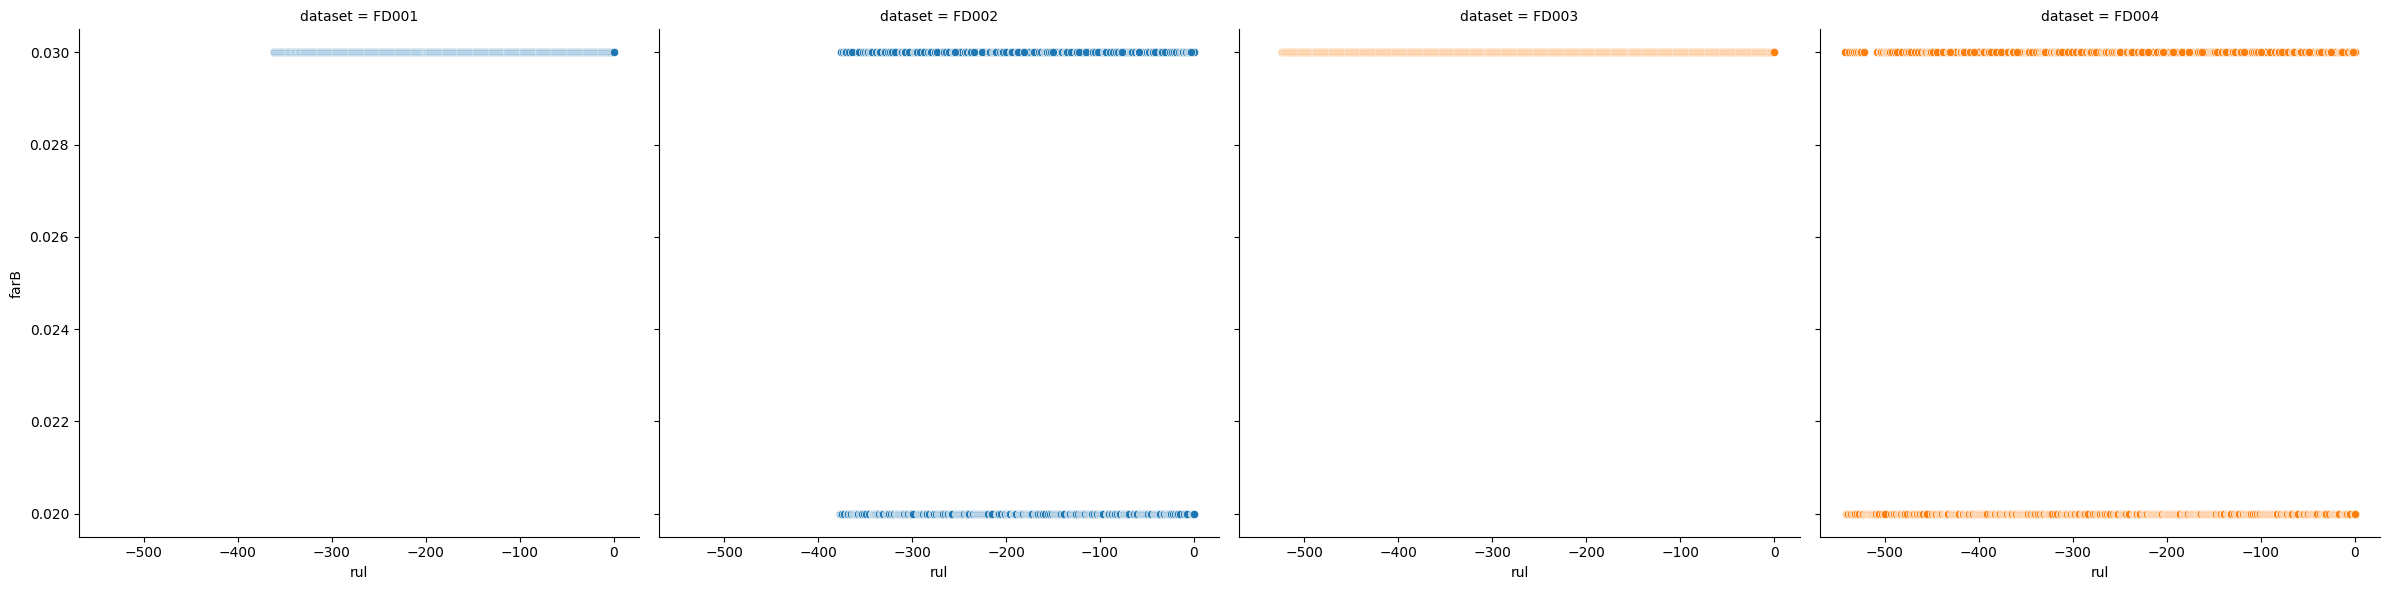

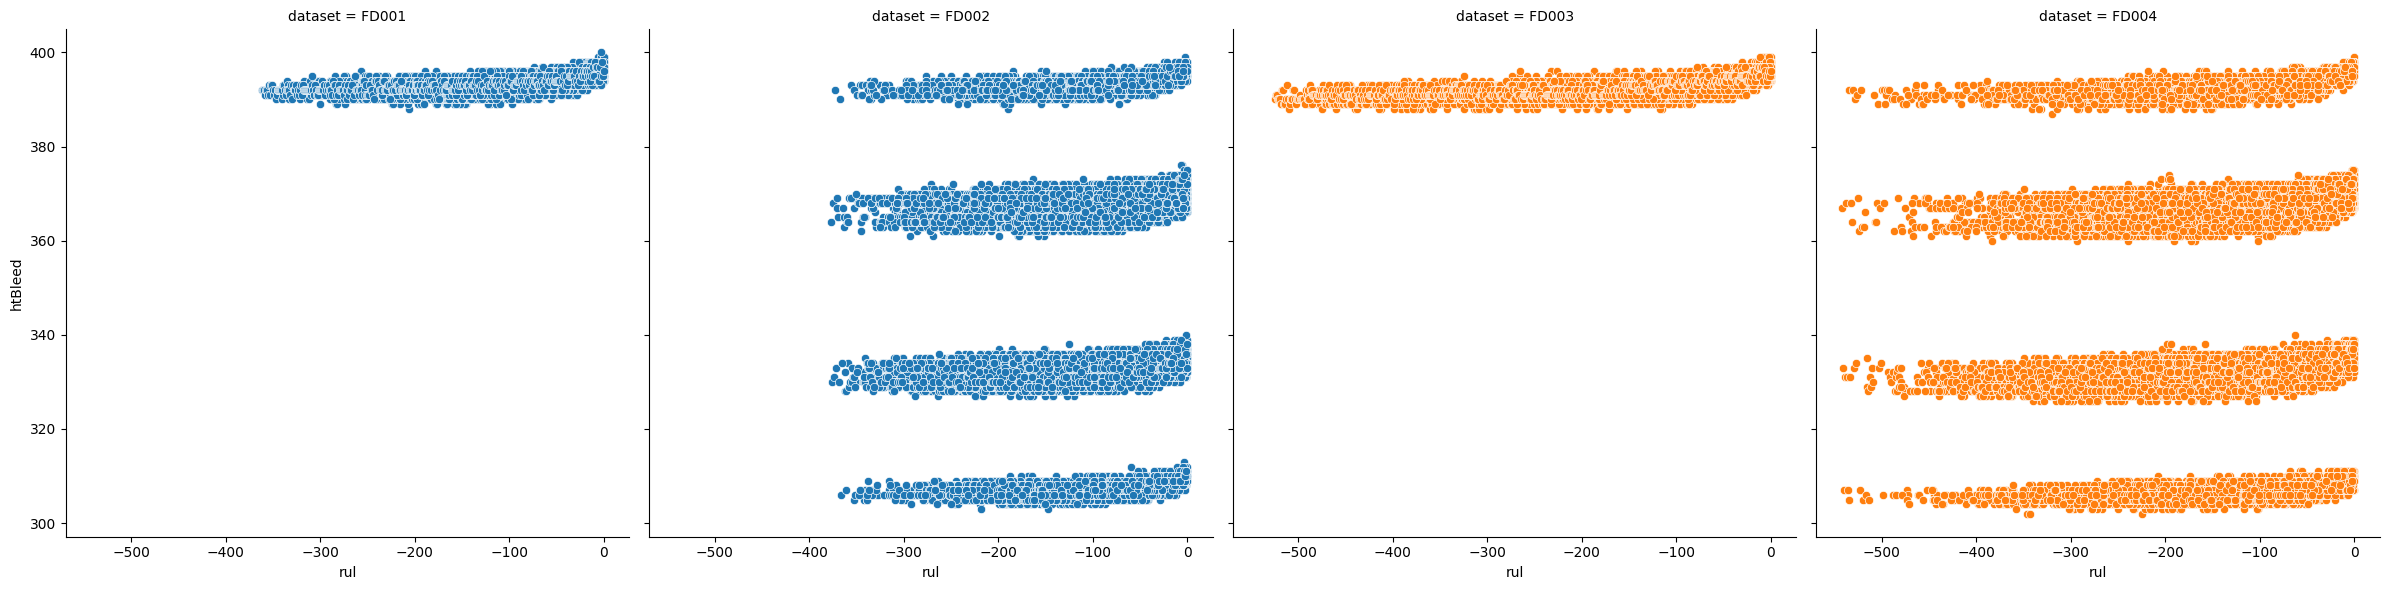

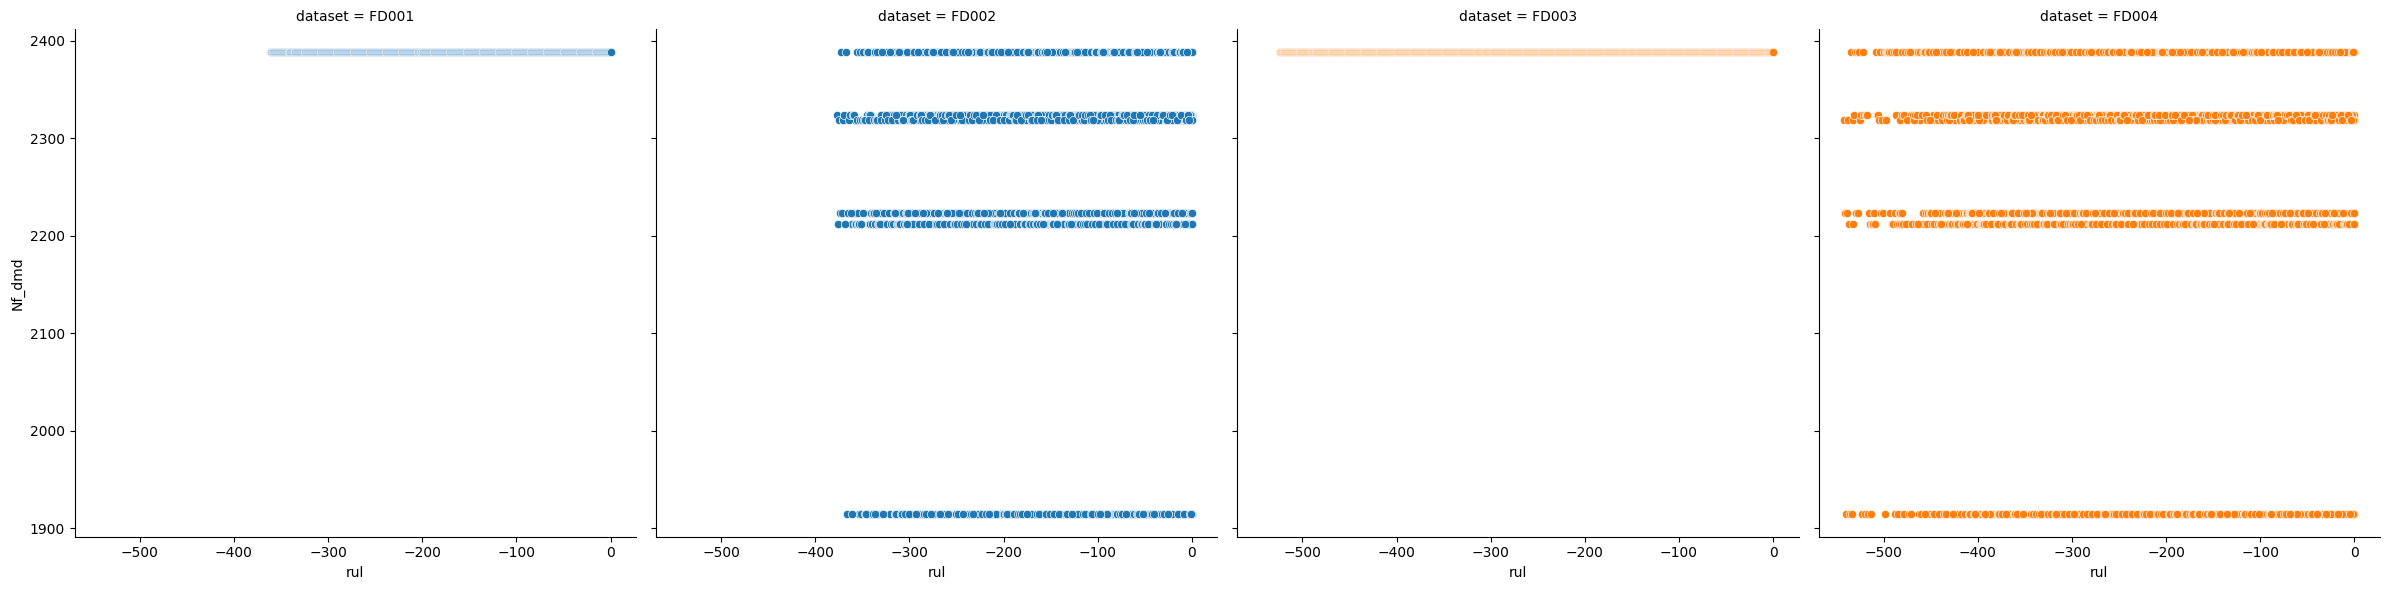

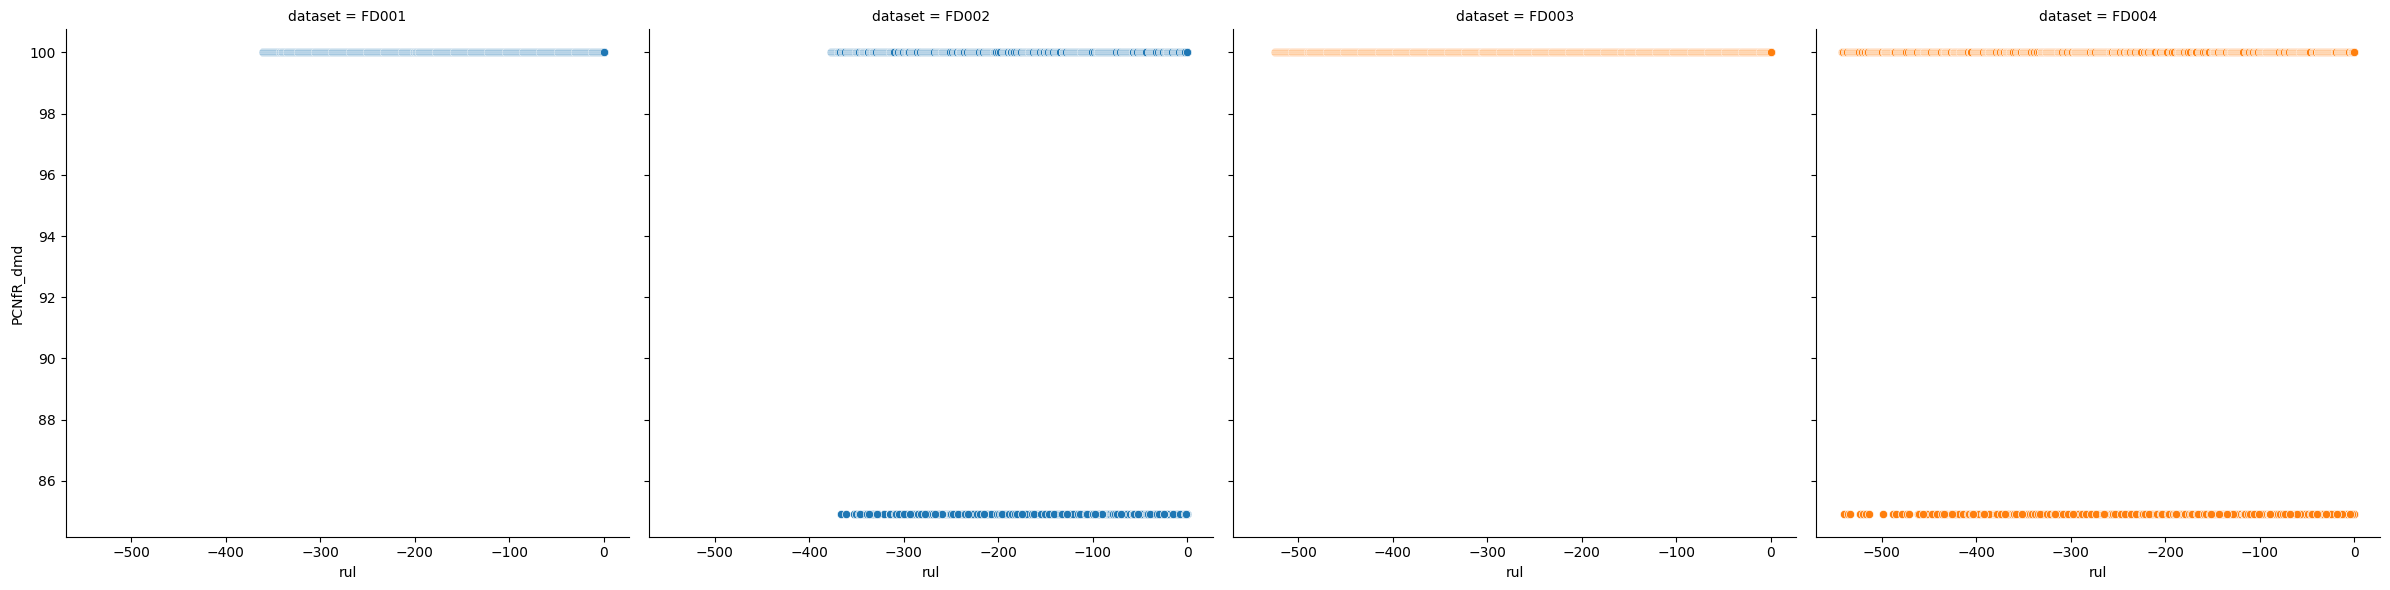

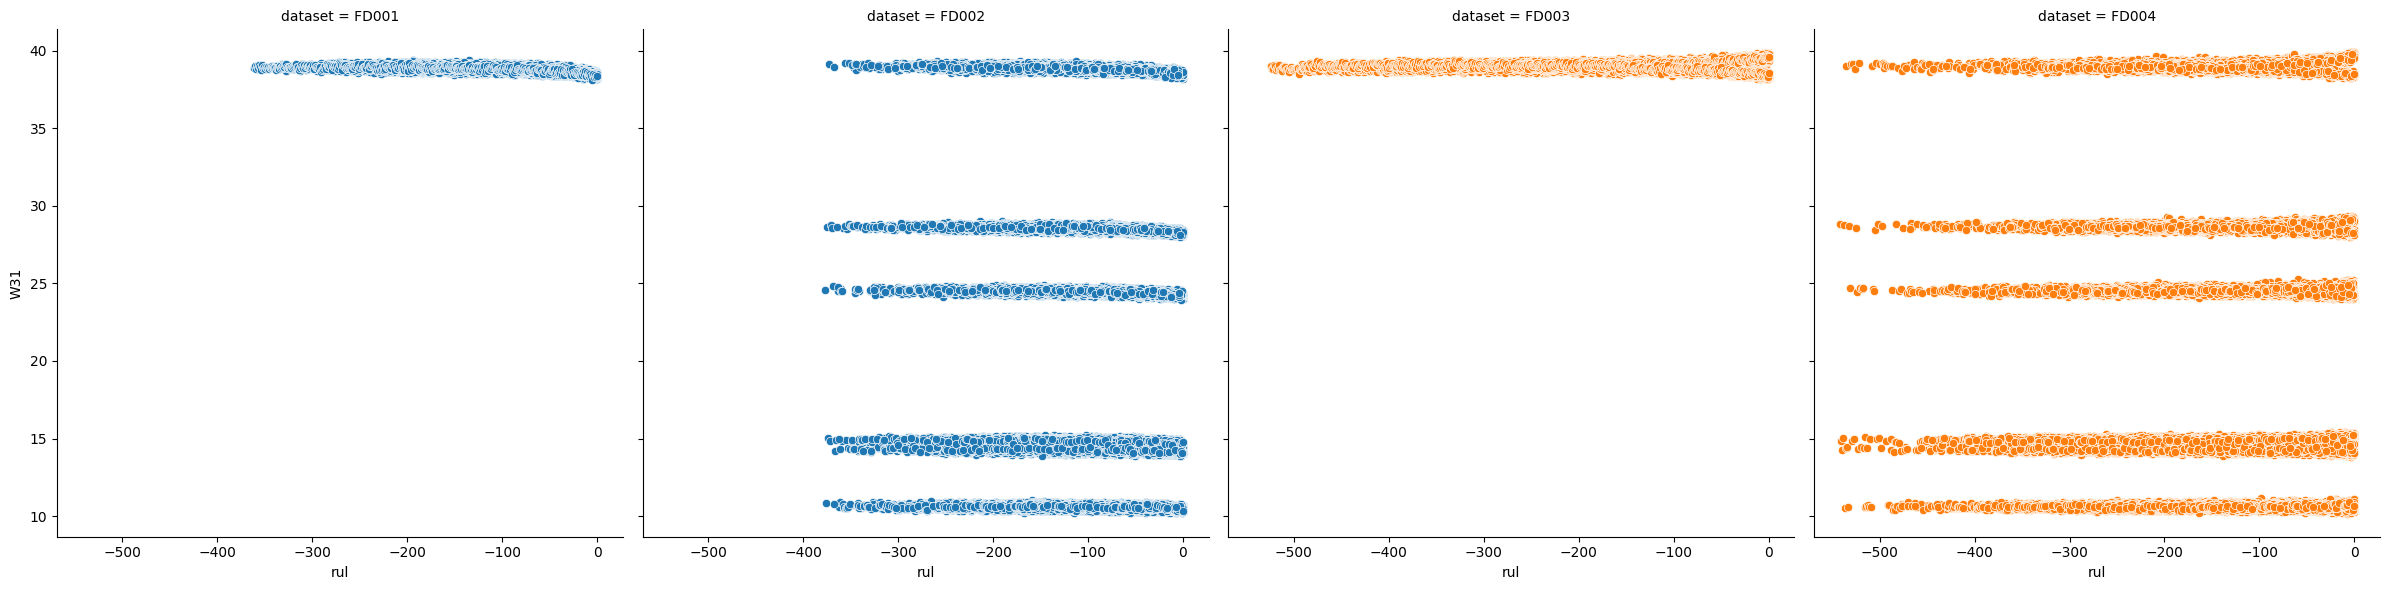

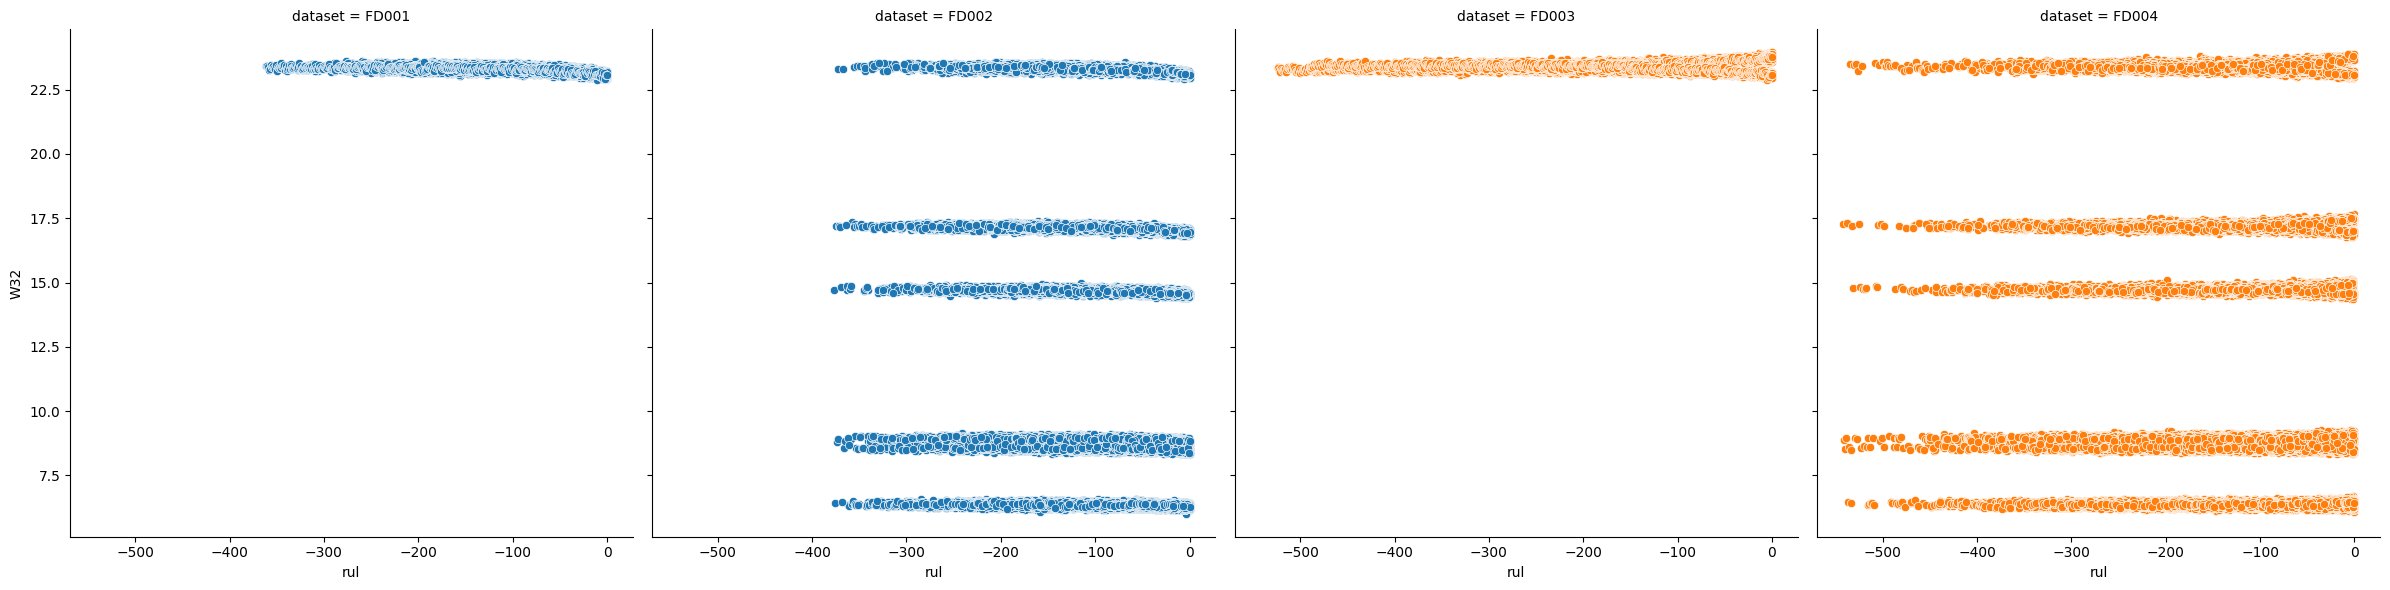

In [17]:
for sensor in sensors:    
    g = sns.FacetGrid(data = train, col = "dataset", hue = "HPC_Fan", size = 6)
    g.map(sns.scatterplot, "rul", sensor)
    plt.show()

In [18]:
X_variables = [
    'T24',
    'T30',
    'T50',
    'P30',
    'Nc',
    'epr',
    'Ps30',
    'phi',
    'NRc',
    'BPR', #ByPass Ratio
    'htBleed',
    'W31',
    'W32',
    'HPC_Fan',
    'c2', # condition 2
    'c3', # condition 3
    'c4', # condition 4
    'c5', # condition 5
    'c6', # condition 6
]

In [ ]:
X = train[X_variables]
y = train["Class"]

In [36]:
def lightgbm(df_train):

    X_variables = [
        'T24',
        'T30',
        'T50',
        'P30',
        'Nc',
        'epr',
        'Ps30',
        'phi',
        'NRc',
        'BPR', #ByPass Ratio
        'htBleed',
        'W31',
        'W32',
        'HPC_Fan',
        'c2', # condition 2
        'c3', # condition 3
        'c4', # condition 4
        'c5', # condition 5
        'c6', # condition 6
    ]

    output = []
    for value in range(-110, 0, 10):
        
        def make_y(row ,lt= value):
            return 1 if row["rul"] > lt else 0
        df_train['Class'] = df_train.apply(make_y, axis = 1)

        X = df_train[X_variables]
        y = df_train["Class"]

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

        ltb = LGBMClassifier()
        ltb.fit(X_train, y_train)
        y_pred = ltb.predict(X_val)
        y_pred_proba = ltb.predict_proba(X_val)[::,1]
        auc = roc_auc_score(y_val, y_pred_proba)
        output.append([value, ltb, X_val, y_pred, y_val, y_pred_proba, auc])   
    return output



In [37]:
lightgbm_output = lightgbm(train)

In [ ]:
from sklearn.metrics import precision_recall_curve
y_pred_proba = ltb.predict_proba(X_val)[::,1]
#fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = precision_recall_curve(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [38]:
for out in lightgbm_output:
    print(f"value is {out[0]}")
    print(f"auc is {out[-1]}")
    print(10*"-")

value is -110
auc is 0.9042773583888459
----------
value is -100
auc is 0.916767948794678
----------
value is -90
auc is 0.9293914933869687
----------
value is -80
auc is 0.9417037135767283
----------
value is -70
auc is 0.9538368007480101
----------
value is -60
auc is 0.9653680487780762
----------
value is -50
auc is 0.9747770693469825
----------
value is -40
auc is 0.9820751911639762
----------
value is -30
auc is 0.9880460544171865
----------
value is -20
auc is 0.991860948685965
----------
value is -10
auc is 0.9931714699510044
----------


In [ ]:
display = PrecisionRecallDisplay.from_estimator(
    ltb, X_val, y_val, name="LightGBM"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")